# **Escrevendo um novo capítulo de um livro como Lewis Carroll**

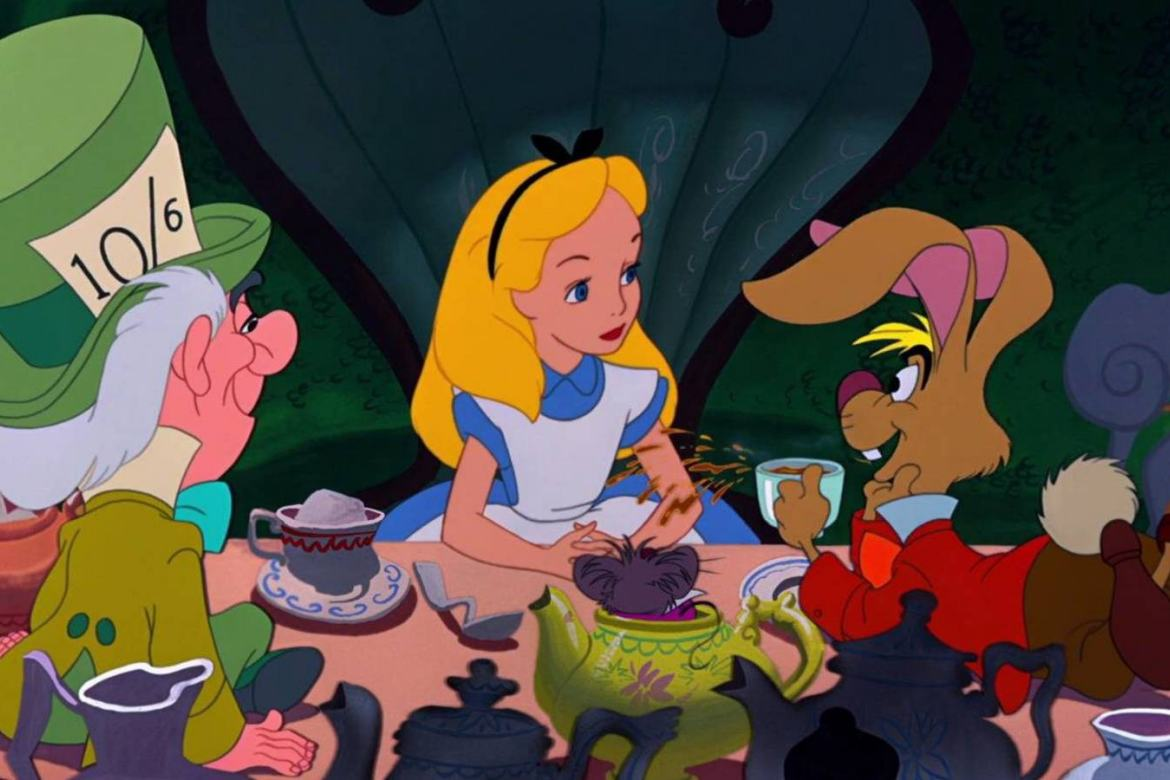




Código de inspiração: https://www.tensorflow.org/text/tutorials/text_generation?hl=pt-br

Nessa aula vamos escrver um novo capítulo de um livro utilizando as redes neurais recorrentes!

## Importando as bibliotecas necessárias

In [1]:
import tensorflow as tf

import numpy as np
import os
import time
import pandas as pd

## Realizando o upload da base de dados

Nesse caso, a nossa base de dados é todo o livro da Alice.

In [2]:
# Lendo o arquivo
text = open('wonderland.txt', 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(text)} characters')

Length of text: 147683 characters


In [3]:
# Visualizando uma amostragem das 300 primeiras palavras
print(text[:300])

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Al


In [4]:
# Total de caracteres únicos no arquivo
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

70 unique characters


# Vetorização do texto

Agora será preciso converter as strings em uma representação numérica.

A camada **tf.keras.layers.StringLookup** pode converter cada caractere em um ID numérico. Ele só precisa que o texto seja dividido em tokens primeiro.

In [5]:
# Exemplo do uso de tokenização simples com unidecode slplit
example_texts = ['alice', 'coelho']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'l', b'i', b'c', b'e'], [b'c', b'o', b'e', b'l', b'h', b'o']]>

In [6]:
# Utilizando o StringLookup
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [7]:
# Analisando os IDs unicos
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[45, 56, 53, 47, 49], [47, 59, 49, 56, 52, 59]]>

Como o objetivo é gerar texto, também será importante inverter essa representação e recuperar os tokens originais. Para isso você pode usar tf.keras.layers.StringLookup(..., invert=True) .

In [8]:
# Se eu trazer a opção invert=True, ele traz de volta cada token
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [9]:
chars = chars_from_ids(ids) # conversão de cada token
chars

<tf.RaggedTensor [[b'a', b'l', b'i', b'c', b'e'], [b'c', b'o', b'e', b'l', b'h', b'o']]>

In [10]:
# Você pode tf.strings.reduce_join para juntar os caracteres de volta em strings.

tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'alice', b'coelho'], dtype=object)

In [11]:
# Criando uma função para gerar texto a partir dos IDs (vamos utiliza-la logo mais!)
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Dado um caractere, ou uma sequência de caracteres, qual é o próximo caractere mais provável? Essa é a tarefa para a qual você está treinando o modelo. A **entrada para o modelo será uma sequência de caracteres**, e você treina o modelo para prever a saída — o caractere a seguir em cada etapa de tempo.


In [12]:
# Pegando a lista de IDs do texto
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(147683,), dtype=int64, numpy=array([18, 23, 16, ...,  1,  2,  1])>

In [13]:
# Converter o vetor de texto em um fluxo de índices de caracteres.
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [14]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

C
H
A
P
T
E
R
 
I
.


In [15]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [16]:
# O método batch permite converter facilmente esses caracteres individuais em sequências do tamanho desejado.
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'C' b'H' b'A' b'P' b'T' b'E' b'R' b' ' b'I' b'.' b' ' b'D' b'o' b'w'
 b'n' b' ' b't' b'h' b'e' b' ' b'R' b'a' b'b' b'b' b'i' b't' b'-' b'H'
 b'o' b'l' b'e' b'\r' b'\n' b'\r' b'\n' b'A' b'l' b'i' b'c' b'e' b' ' b'w'
 b'a' b's' b' ' b'b' b'e' b'g' b'i' b'n' b'n' b'i' b'n' b'g' b' ' b't'
 b'o' b' ' b'g' b'e' b't' b' ' b'v' b'e' b'r' b'y' b' ' b't' b'i' b'r'
 b'e' b'd' b' ' b'o' b'f' b' ' b's' b'i' b't' b't' b'i' b'n' b'g' b' '
 b'b' b'y' b' ' b'h' b'e' b'r' b' ' b's' b'i' b's' b't' b'e' b'r' b' '
 b'o' b'n' b' '], shape=(101,), dtype=string)


É mais fácil ver o que isso está fazendo se você juntar os tokens de volta em strings:

In [17]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'CHAPTER I. Down the Rabbit-Hole\r\n\r\nAlice was beginning to get very tired of sitting by her sister on '
b'the\r\nbank, and of having nothing to do: once or twice she had peeped into the\r\nbook her sister was re'
b"ading, but it had no pictures or conversations in\r\nit, 'and what is the use of a book,' thought Alice"
b" 'without pictures or\r\nconversations?'\r\n\r\nSo she was considering in her own mind (as well as she coul"
b'd, for the\r\nhot day made her feel very sleepy and stupid), whether the pleasure\r\nof making a daisy-ch'


Para treinamento, você precisará de um conjunto de dados de pares (input, label) . Onde input e label são sequências. A cada passo de tempo, a entrada é o caractere atual e o rótulo é o próximo caractere.

Essa função a seguir tem o objetivo é **preparar pares de entrada e saída para treinar um modelo de predição de sequência**. Ao fazer isso, cada entrada tem a tarefa de prever o próximo caractere na sequência.

In [18]:
def split_input_target(sequence):
    input_text = sequence[:-1] # todos os elementos da sequência original, exceto o último
    target_text = sequence[1:] # pega todos os elementos da sequência original, exceto o primeiro
    return input_text, target_text

In [19]:
split_input_target(list("Rainha"))

(['R', 'a', 'i', 'n', 'h'], ['a', 'i', 'n', 'h', 'a'])

In [20]:
dataset = sequences.map(split_input_target)  # Esse código aplica a função split_input_target a cada elemento do dataset chamado sequences usando o método map

In [21]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'CHAPTER I. Down the Rabbit-Hole\r\n\r\nAlice was beginning to get very tired of sitting by her sister on'
Target: b'HAPTER I. Down the Rabbit-Hole\r\n\r\nAlice was beginning to get very tired of sitting by her sister on '


# Criar lotes de treinamento

Você usou tf.data para dividir o texto em sequências gerenciáveis. Mas antes de alimentar esses dados no modelo, você precisa embaralhar os dados e empacotá-los em lotes.

In [22]:

# Define o tamanho do lote (batch size)
BATCH_SIZE = 64

# Define o tamanho do buffer para embaralhar o dataset
# (O TF data é projetado para trabalhar com sequências possivelmente infinitas,
# então ele não tenta embaralhar a sequência inteira na memória. Em vez disso,
# ele mantém um buffer no qual embaralha os elementos).
BUFFER_SIZE = 10000

# Aplica operações no dataset:
dataset = (
    dataset
    # Embaralha o dataset usando o tamanho do buffer definido
    .shuffle(BUFFER_SIZE)
    # Agrupa os elementos em lotes de tamanho definido (BATCH_SIZE)
    # drop_remainder=True garante que apenas lotes completos sejam mantidos
    .batch(BATCH_SIZE, drop_remainder=True)
    # Pré-carrega os lotes para otimizar a performance de treinamento
    # tf.data.experimental.AUTOTUNE ajusta automaticamente o pré-carregamento
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Retorna o dataset processado
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Construir o modelo de rede neural

Este modelo tem três camadas:

- **tf.keras.layers.Embedding** : A camada de entrada. Uma tabela de pesquisa treinável que mapeará cada ID de caractere para um vetor com dimensões embedding_dim.

- **tf.keras.layers.GRU** : Um tipo de RNN com units=rnn_units (Você também pode usar uma camada LSTM aqui.). A camada GRU (Gated Recurrent Unit) é um tipo de unidade em redes neurais recorrentes (RNNs) que é projetada para resolver alguns dos problemas comuns encontrados em RNNs tradicionais, como o problema do gradiente desaparecido. As GRUs são uma variante das LSTMs (Long Short-Term Memory), mas são mais simples em termos de arquitetura.

- **tf.keras.layers.Dense** : A camada de saída, com saídas vocab_size . Ele gera um logit para cada caractere no vocabulário. Estas são as probabilidades de log de cada personagem de acordo com o modelo.


In [24]:
# Tamanho do vocabulário
vocab_size = len(vocab)

# Tamanho da dimensão de embedding
embedding_dim = 256

# Número de memórias RNN
rnn_units = 1024

In [25]:
# Definição da classe do modelo, que herda de tf.keras.Model
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super(MyModel, self).__init__()
    # Camada de embedding que converte IDs de palavras em vetores densos de dimensão embedding_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Camada GRU com o número de unidades especificado, retornando sequências completas e estado final
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    # Camada densa que transforma as saídas da GRU em logits para cada palavra no vocabulário
    # As saídas da GRU (Gated Recurrent Unit) em logits referem-se aos valores numéricos não normalizados produzidos pela camada densa após a GRU.
    # Esses valores representam a pontuação ou a "logit" para cada classe do vocabulário, antes de serem passados por uma função de ativação, como softmax,
    # para converter essas pontuações em probabilidades.
    self.dense = tf.keras.layers.Dense(vocab_size)

  # Definição do método call, que especifica como os dados passam pelo modelo
  def call(self, inputs, states=None, return_state=False, training=False):
    # Entrada inicial
    x = inputs
    # Aplicação da camada de embedding às entradas
    x = self.embedding(x, training=training)
    # Se nenhum estado inicial for fornecido, inicializa o estado da GRU
    if states is None:
      states = [tf.zeros((x.shape[0], self.gru.units))]
    # Passa os embeddings pela GRU, obtendo as saídas e o novo estado
    x, states = self.gru(x, initial_state=states, training=training)
    # Passa as saídas da GRU pela camada densa para obter logits
    x = self.dense(x, training=training)

    # Se return_state for True, retorna as saídas e o estado; caso contrário, retorna apenas as saídas
    if return_state:
      return x, states
    else:
      return x

# Instanciação do modelo MyModel com os parâmetros fornecidos
model = MyModel(
    # Certifique-se de que o tamanho do vocabulário corresponde ao das camadas StringLookup
    vocab_size=len(ids_from_chars.get_vocabulary()),  # Tamanho do vocabulário
    embedding_dim=embedding_dim,                      # Dimensão dos embeddings
    rnn_units=rnn_units)                              # Número de unidades da GRU


Para cada caractere, o modelo procura a incorporação, executa a GRU um passo de tempo com a incorporação como entrada e aplica a camada densa para gerar logits prevendo a probabilidade de log do próximo caractere:

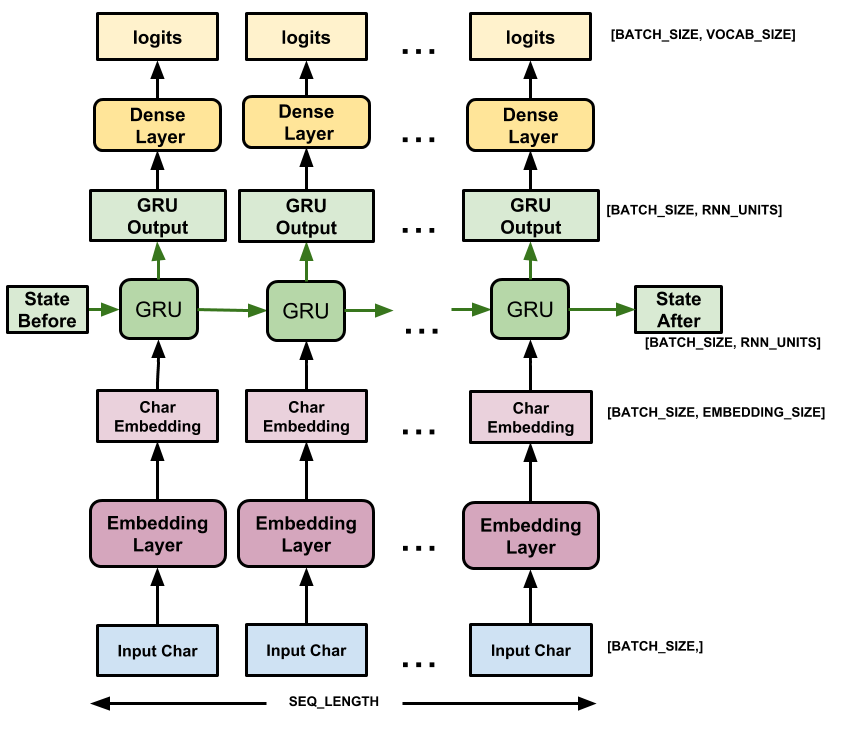

Basicamente dada uma sequência de IDs de palavras codificadas usando uma função como ids_from_chars.

A camada de embedding converte esses IDs em vetores de embedding densos, que são usados como entrada para a camada GRU.

A camada GRU processa as sequências de vetores de embedding e gera novas sequências de vetores, capturando a dependência entre as palavras.

A camada densa transforma as saídas da GRU em logits para cada palavra no vocabulário.

# Experimente o modelo
Agora execute o modelo para ver se ele se comporta conforme o esperado.

Primeiro verifique a forma da saída:

In [26]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 71) # (batch_size, sequence_length, vocab_size)


In [27]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  18176     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  72775     
                                                                 
Total params: 4029255 (15.37 MB)
Trainable params: 4029255 (15.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Experimente para o primeiro exemplo no lote:

In [28]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Isso nos dá, a cada passo de tempo, uma previsão do próximo índice de caracteres:

In [29]:
sampled_indices

array([50, 67, 42, 68, 25, 43, 22, 46, 41, 20, 10,  7, 56, 55, 61, 18, 22,
        0, 55,  8, 44, 39, 54, 54, 53, 68, 25, 36, 51,  3, 12,  9, 28, 32,
       62, 41, 37, 63, 55,  7,  0, 40, 34, 37,  4,  7, 46, 38, 63, 51, 57,
       11, 57, 38, 48, 35, 36, 52, 13,  7, 55, 12, 70, 48, 32,  7, 40, 23,
       58, 56, 33, 32, 35, 58, 11, 49, 49, 29, 67, 57, 58, 35,  1,  4, 36,
       18, 12, 63, 66, 46,  6,  5, 30, 17, 53, 50, 17, 45, 11, 21])

Decodifique-os para ver o texto previsto por este modelo não treinado:

In [30]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' round. (It was this last\r\nremark that had made the whole party look so grave and anxious.)\r\n\r\nAlice'

Next Char Predictions:
 b'fw[xJ]GbZE,(lkqCG[UNK]k)_XjjixJUg .*MQrZVsk([UNK]YSV!(bWsgm-mWdTUh:(k.zdQ(YHnlRQTn-eeNwmnT\n!UC.svb\'"OBifBa-F'


# Treine o modelo
Neste ponto, o problema pode ser tratado como um problema de classificação padrão. Dado o estado RNN anterior e a entrada neste passo de tempo, preveja a classe do próximo caractere.

Anexe um otimizador e uma função de perda
A função de perda padrão tf.keras.losses.sparse_categorical_crossentropy funciona nesse caso porque é aplicada na última dimensão das previsões.

Como seu modelo retorna logits, você precisa definir o sinalizador from_logits .

In [31]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 71)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.2636237, shape=(), dtype=float32)


Um modelo recém-inicializado não deve ser muito seguro de si mesmo, todos os logits de saída devem ter magnitudes semelhantes. Para confirmar isso, você pode verificar que o exponencial da perda média é aproximadamente igual ao tamanho do vocabulário. Uma perda muito maior significa que o modelo está certo de suas respostas erradas e está mal inicializado:

In [33]:
tf.exp(example_batch_mean_loss).numpy()

71.06705

Configure o procedimento de treinamento usando o método tf.keras.Model.compile . Use tf.keras.optimizers.Adam com argumentos padrão e a função de perda.

In [34]:
model.compile(optimizer='adam', loss=loss)

In [35]:
# Diretório onde o checkpoint será salvo
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Execute o treinamento
Para manter o tempo de treinamento razoável, use 10 épocas para treinar o modelo. No Colab, defina o tempo de execução para GPU para um treinamento mais rápido.

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
22/22 [==============================] - 128s 5s/step - loss: 4.0788
Epoch 2/20
22/22 [==============================] - 115s 5s/step - loss: 3.0831
Epoch 3/20
22/22 [==============================] - 113s 5s/step - loss: 2.7425
Epoch 4/20
22/22 [==============================] - 113s 5s/step - loss: 2.4881
Epoch 5/20
22/22 [==============================] - 108s 5s/step - loss: 2.3553
Epoch 6/20
22/22 [==============================] - 108s 5s/step - loss: 2.2580
Epoch 7/20
22/22 [==============================] - 109s 5s/step - loss: 2.1738
Epoch 8/20
22/22 [==============================] - 110s 5s/step - loss: 2.0945
Epoch 9/20
22/22 [==============================] - 109s 5s/step - loss: 2.0131
Epoch 10/20
22/22 [==============================] - 111s 5s/step - loss: 1.9352
Epoch 11/20
22/22 [==============================] - 107s 5s/step - loss: 1.8644
Epoch 12/20
22/22 [==============================] - 108s 5s/step - loss: 1.7985
Epoch 13/20
22/22 [==================

# Gerar texto
A maneira mais simples de gerar texto com esse modelo é executá-lo em um loop e acompanhar o estado interno do modelo à medida que você o executa.

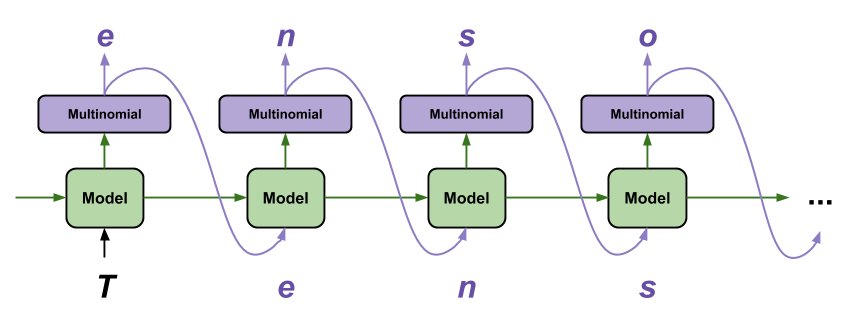

Cada vez que você chama o modelo você passa algum texto e um estado interno. O modelo retorna uma previsão para o próximo caractere e seu novo estado. Passe a previsão e o estado de volta para continuar gerando texto.

O seguinte faz uma previsão de uma única etapa:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    # Chama o construtor da classe base
    super().__init__()
    # Define a temperatura para ajuste da aleatoriedade da geração
    # temperature: um parâmetro opcional para ajustar a aleatoriedade da geração (padrão é 1.0)
    self.temperature = temperature
    # Define o modelo subjacente a ser usado para previsão
    self.model = model
    # Mapeamento de IDs para caracteres
    self.chars_from_ids = chars_from_ids
    # Mapeamento de caracteres para IDs
    self.ids_from_chars = ids_from_chars

    # Cria uma máscara para impedir a geração do token "[UNK]"
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Coloca -inf em cada índice a ser evitado
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Ajusta a forma ao vocabulário
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    # Converte a máscara esparsa em uma densa
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Converte strings em IDs de tokens
    # chars_from_ids: uma função que mapeia IDs para caracteres
    # ids_from_chars: uma função que mapeia caracteres para IDs
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Executa o modelo
    # predicted_logits.shape é [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Usa apenas a última previsão
    predicted_logits = predicted_logits[:, -1, :]
    # Ajusta os logits pela temperatura
    predicted_logits = predicted_logits/self.temperature
    # Aplica a máscara de previsão para evitar a geração de "[UNK]"
    predicted_logits = predicted_logits + self.prediction_mask

    # Amostra os logits de saída para gerar IDs de tokens
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Converte de IDs de tokens para caracteres
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Retorna os caracteres e o estado do modelo
    return predicted_chars, states

# Exemplo de instância da classe OneStep:
# model: um modelo de previsão de texto (por exemplo, um modelo GRU ou LSTM treinado)

#
# one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature=1.0)


In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Execute-o em um loop para gerar algum texto. Observando o texto gerado, você verá que o modelo sabe quando capitalizar, fazer parágrafos e imita um vocabulário de escrita semelhante a de Lewis Carroll. Com o pequeno número de épocas de treinamento, ainda não aprendeu a formar frases coerentes.

In [ ]:
start = time.time() # Inicia o cronômetro para medir o tempo de execução
states = None # Inicializa o estado da RNN como None

next_char = tf.constant(['Alice:']) # Define a string inicial para a geração de texto

result = [next_char] # Cria uma lista para armazenar os caracteres gerados

# Loop para gerar 1000 caracteres
for n in range(1000):
  # Gera o próximo caractere e o novo estado do modelo
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  # Adiciona o caractere gerado à lista de resultados
  result.append(next_char)

# Junta todos os caracteres gerados em uma única string
result = tf.strings.join(result)
# Para o cronômetro e calcula o tempo de execução
end = time.time()

# Imprime o texto gerado
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

# Imprime o tempo de execução
print('\nRun time:', end - start)


Alice: 'So Alice, wenter to Alive, littered like one om the restand believe about at the mack was no one of the deautity.

Now the pires befur little for
the dige: at when I did THANE sayting propicharec,' Alice semperter the looked in a say; 'to begner the wite of beginning get in ug another my. For a pircless comserself in retios--bothing about it slaple
lired it a witch sneess to hisnersals, 'furning plose
serpither waring of the sharpully.

The Know voice to eas all oven eye listed, and threawing pase or nexturcet.

'Chash, then a yectle said
onice,' said the Caterpillar, of
she talked of the
criquecle of
finich telles: she eat in aid notichanges at the deart of fentainly firs what Duch,
      *
       *  ont it!' said Alice.

'Why,!' pees quesliom. 'I tealing patting ho herell, 'bit, I chink about your trouble then, she had
duck canteres, and herself up one, as very unjust the Queen wall of clasted:, as she sougd dittening,
to din, said to Alice.

Jettenty as it all. 

___________